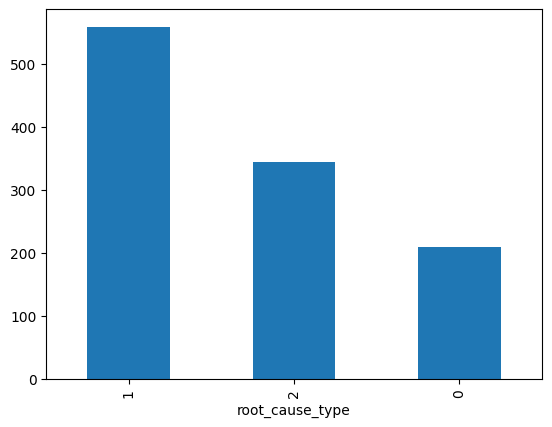

In [1]:
# 1. 데이터 로드
import pandas as pd
import matplotlib.pyplot as plt

def ppr_data(df):
    # TODO: 데이터 전처리 코드 구현 ---------- #
    df = df.groupby('ticketno').apply(custom_info).reset_index()  # ticketno 기준 병합 및 전처리 수행

    x_df = df.iloc[:, :-1]
    y_df = df['root_cause_type']
    
    y_df.value_counts().plot(kind = 'bar') if y_df[0] is not None else None  # 레이블 분포 확인
    
    # ------------------------------------- #
    return x_df, y_df

def custom_info(group):  # 임의로 작성된 전처리 코드입니다.
    d = {}
    group.sort_values(by='alarmtime', ascending=True, inplace=True)  # 경보 순서 정렬
    d['alarmmsg_original'] = ' '.join(group['alarmmsg_original'])  # 메시지 단순 병합
    if 'root_cause_type' in group.columns:  # 레이블 추출
        group['root_cause_type'] = group['root_cause_type'].apply(lambda x: 0 if x == 'PowerFail' else (1 if x == 'LinkCut' else 2))  # 레이블 인코딩
        d['root_cause_type'] = group['root_cause_type'].iloc[0]  # 동일한 ticketno는 동일한 root_cause_type을 가짐
    else:
        d['root_cause_type'] = None  # 테스트 세트의 경우 정답 컬럼 없음
    return pd.Series(d, index=['alarmmsg_original', 'root_cause_type'])

train_df = pd.read_csv("Q2_train.csv")
test_df = pd.read_csv("Q2_test.csv")

x_train_df, y_train_df = ppr_data(train_df)
x_test_df, _ = ppr_data(test_df)  # 테스트 세트의 경우 정답 컬럼 없음

# print(x_train_df,'\n', y_train_df)
# print(x_test_df)

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
import numpy as np
import time
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sentence_transformers import SentenceTransformer

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

# 2. 모델 학습 및 예측
class MyModel:
    def __init__(self) -> None:
        self.model = model
        self.max_len = 256 # 문장 최대 길이
        self.epoch = 10 # 학습 횟수

    def train(self, x_train, y_train):
        #x_ticketno = x_train['ticketno'].values
        x_alarmmsg_original = x_train['alarmmsg_original'].values
        y_root_cause_type = y_train.values

        input_ids = []
        attention_masks = []
        #token_type_ids = []

        for i, message in enumerate(x_alarmmsg_original):
            encoded_dict = tokenizer.encode_plus(
                                message,                       # 문장
                                add_special_tokens = True,     # 문장 맨 앞, 뒤에 [CLS], [SEP] 추가
                                max_length = self.max_len,     # 문장 최대 길이
                                pad_to_max_length = True,      # 문장 길이가 짧으면 패딩 추가
                                return_attention_mask = True,  # 어텐션 마스크 생성
                                return_tensors = 'pt',         # 파이토치 텐서 반환
                           )
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])

        # 리스트를 텐서로 변환
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        labels = torch.tensor(y_root_cause_type)
        print('input_ids : ', input_ids, ' / ', input_ids.shape)
        print('attention_masks : ', attention_masks, ' / ', attention_masks.shape)
        print('labels : ', labels, ' / ', labels.shape)

        print('------------------------------ tokenizing end ------------------------------\n')

        # 모델 학습
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-5)  # AdamW 옵티마이저 사용, 학습률은 2e-5

        # 데이터 로더 설정
        dataset = TensorDataset(input_ids, attention_masks, labels)
        train_sampler = RandomSampler(dataset)
        train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=32)

        # 학습 반복
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(device)
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        t0 = time.time()
        format_time = lambda elapsed: time.strftime("%H:%M:%S", time.gmtime(elapsed))

        for epoch_i in range(self.epoch):
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, self.epoch))
            total_loss = 0
            self.model.train()
            for step, batch in enumerate(train_dataloader):
                if step % 100 == 0 and not step == 0:
                    elapsed = format_time(time.time() - t0)
                    print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
                batch = tuple(t.to(device) for t in batch)
                inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
                outputs = self.model(**inputs)
                loss = outputs.loss
                total_loss += loss.item()
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            avg_loss = total_loss / len(train_dataloader)
            print('  Average training loss: {0:.4f}'.format(avg_loss))
            print('  Training epcoh took: {:}'.format(format_time(time.time() - t0)))

        # 모델 저장
        self.model.save_pretrained("saved_model")
        tokenizer.save_pretrained("saved_model")
        torch.save(self.model, 'saved_model/model.pt')
        
        print('------------------------------ train end ------------------------------\n')

        pass

    def predict(self, x_test):
        x_alarmmsg_original = x_test['alarmmsg_original'].values
        input_ids = []
        attention_masks = []

        for i, message in enumerate(x_alarmmsg_original):
            encoded_dict = tokenizer.encode_plus(
                                message,                       # 문장
                                add_special_tokens = True,     # 문장 맨 앞, 뒤에 [CLS], [SEP] 추가
                                max_length = self.max_len,     # 문장 최대 길이
                                pad_to_max_length = True,      # 문장 길이가 짧으면 패딩 추가
                                return_attention_mask = True,  # 어텐션 마스크 생성
                                return_tensors = 'pt',         # 파이토치 텐서 반환
                           )
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])
        
        # 리스트를 텐서로 변환
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)

        # 데이터 로더 설정
        dataset = TensorDataset(input_ids, attention_masks)
        test_sampler = SequentialSampler(dataset)
        test_dataloader = DataLoader(dataset, sampler=test_sampler, batch_size=16)

        # 예측
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(device)
        self.model.eval()

        pred = []
        for batch in test_dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
            with torch.no_grad():
                outputs = self.model(**inputs)
            logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            pred.append(logits)
        pred = np.concatenate(pred, axis=0)
        pred = np.argmax(pred, axis=1)
        pred = np.where(pred == 0, 'PowerFail', np.where(pred == 1, 'LinkCut', 'UnitFail'))
        print(pred)

        pred_df = pd.DataFrame({'ticketno': x_test['ticketno'].values, 'root_cause_type': pred})

        print('------------------------------ predict end ------------------------------\n')

        return pred_df

model = MyModel()
model.train(x_train_df, y_train_df)
y_pred = model.predict(x_test_df)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you ca

input_ids :  tensor([[    0,  3888,   791,  ...,     1,     1,     1],
        [    0, 31076,    12,  ...,     1,     1,     1],
        [    0,  3888,   791,  ...,     1,     1,     1],
        ...,
        [    0,  5733,   565,  ...,     1,     1,     1],
        [    0,  5733,   565,  ...,     1,     1,     1],
        [    0,  5733,   565,  ...,     1,     1,     1]])  /  torch.Size([1114, 256])
attention_masks :  tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])  /  torch.Size([1114, 256])
labels :  tensor([0, 0, 0,  ..., 1, 1, 1])  /  torch.Size([1114])
------------------------------ tokenizing end ------------------------------

======== Epoch 1 / 10 ========
  Average training loss: 0.2009
  Training epcoh took: 00:04:22
======== Epoch 2 / 10 ========
  Average training loss: 0.0665
  Training epcoh took: 00:08:4

In [3]:
# 3. 결과 제출
# 본 코드는 제출되는 파일의 형태에 대한 가이드로, 반드시 아래 구조를 따를 필요 없이 자유롭게 코드를 작성해도 무방합니다.
# 제출 포맷에 대해선 data/Q2_label_sample.csv를 참조하세요.
#
# 분야 2의 경우, 전표(ticket) 하나에 하나의 근원장애(root_cause_type)을 매칭해야 합니다.
#   주의: 경보(alarm) 개수와 전표(ticket) 개수는 다르며, 예측할 대상은 전표입니다.
#   주의: ticketno 컬럼 기준으로 오름차순 정렬이 필요합니다.
# 분야 2의 제출 파일은 2개 컬럼 [ticketno, root_cause_type]을 가져야 합니다.

def submitResult(pred):
    try:
        label = pd.read_csv('Q2_label_sample.csv')
        # ticketno 순서와 개수가 일치하는지 확인
        if (label['ticketno'] == pred['ticketno']).all():
            print("Check: ticketno 순서와 샘플 수가 일치합니다.")
        else:
            print("Warning: 테스트 세트와 모델 예측의 ticketno가 일치하지 않습니다.")
            return

        pred.to_csv('Q2_submitResult.csv', index=False)
        print("Done : Q2_submitResult.csv 파일로 저장되었습니다.")
    except Exception as e:
        # 예외가 발생한 경우 오류 메시지 출력
        print("Error:", e)

submitResult(y_pred)

Check: ticketno 순서와 샘플 수가 일치합니다.
Done : Q2_submitResult.csv 파일로 저장되었습니다.


In [4]:
# GPU reset

from numba import cuda

device = cuda.get_current_device(); device.reset()